# Blight Prediction - Capstone Project

## Get the Data

Note - I downloaded this Detroit Demolition dataset to use rather than one of building permits provided
by instructor since it was cleaner data and contained only the essential fields needed to label known blight
locations.

We begin with downloading the data from [Detroit Open Data Portal](https://data.detroitmi.gov/). There are five data files used in this analysis:
* `Detroit_Demolitions.csv` : each record represents a demolition executed up to date
* `Upcoming_Detroit_Demolitions.csv` : each record represents an upcoming demolition
* `Blight_Violations.csv` : each record represents a blight violation incident
* `DPD__All_Crime_Incidents__2009_-_Present__Provisional_.csv` : each record shows a criminal incident in Detroit since 2009
* `Improve_Detroit__Submitted_Issues.csv` : each record represents a issue submitted for consideration through the Improve Detroit website or application (just like a 311 complaining call)

In [26]:
!curl -o Detroit_Demolitions.csv https://data.detroitmi.gov/api/views/rv44-e9di/rows.csv?accessType=DOWNLOAD 
!curl -o Upcoming_Detroit_Demolitions.csv https://data.detroitmi.gov/api/views/tsqq-qtet/rows.csv?accessType=DOWNLOAD
!curl -o Blight_Violations.csv https://data.detroitmi.gov/api/views/teu6-anhh/rows.csv?accessType=DOWNLOAD
!curl -o DPD__All_Crime_Incidents__2009_-_Present__Provisional_.csv https://data.detroitmi.gov/api/views/b4hw-v6w2/rows.csv?accessType=DOWNLOAD

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1301k  100 1301k    0     0  1679k      0 --:--:-- --:--:-- --:--:-- 1679k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 22856  100 22856    0     0  74255      0 --:--:-- --:--:-- --:--:-- 74207
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  157M  100  157M    0     0  6707k      0  0:00:24  0:00:24 --:--:-- 7093k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  249M    0  249M    0     0   984k      0 --:--:--  0:04:19 --:--:-- 1492k


In [12]:
#we can also use urllib to download the file
import urllib
url = 'https://data.detroitmi.gov/api/views/fwz3-w3yn/rows.csv?accessType=DOWNLOAD'
urllib.urlretrieve(url, 'Improve_Detroit__Submitted_Issues.csv') 

('Improve_Detroit__Submitted_Issues.csv',
 <httplib.HTTPMessage instance at 0x103d92dd0>)

## List of Buildings

The first step is to extract a list of buildings from the longitude and lattitude data. To view the location data, I use Google fusion table to create a [map](https://fusiontables.google.com/embedviz?q=select+col7+from+1dZhBHGvqIljSkDyBD5-6Dl6sTVg-qO6jLtIOHcCz&viz=MAP&h=false&lat=42.37727998411888&lng=-83.10039014405822&t=1&z=12&l=col7&y=2&tmplt=2&hml=TWO_COL_LAT_LNG) for the data file `Detroit_Demolitions.csv`. We can see the demolitions are distributed across the entire region of Detroit. Similar map can be created with other data file, which may show a different density of records.

Here we use a simple model to build the list of buildings. We divide the entire landscape into small squares with side of 10 meters long and label each squares as a building. First of all, we need to find the range of the Latitude and Longitude data.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()

In [2]:
#We will read all the data files and find their latitude and longitude range in the following.
demolitions = pd.read_csv('Detroit_Demolitions.csv')
demolitions.describe()

Council_District      Latitude     Longitude
count      10509.000000  10509.000000  10509.000000
mean           4.051670     42.388086    -83.104697
std            1.988426      0.037889      0.099341
min            1.000000     42.256238    -83.285646
25%            3.000000     42.362518    -83.193898
50%            4.000000     42.392587    -83.112846
75%            6.000000     42.417977    -83.009386
max            7.000000     42.449540    -82.913284

In [3]:
Lat_max = max(demolitions['Latitude'])
Lat_min = min(demolitions['Latitude'])
Lon_max = max(demolitions['Longitude'])
Lon_min = min(demolitions['Longitude'])

In [4]:
future_demolitions = pd.read_csv('Upcoming_Detroit_Demolitions.csv')
future_demolitions.head()

Address      Parcel ID                       Contractor Name  \
0     6260 Brace      22080850.                             Blue Star   
1    3000 Carter      12002310.  Salenbien Trucking & Excavating Inc.   
2  4005 Clippert  18010704.002L                         1 Way Service   
3     4751 Alter      21063017.                       DMC Consultants   
4  9946 Somerset      21067196.     Direct Construction Services, LLC   

       Price Projected Demolished By Date Commercial Building  \
0  $18300.00                   10/05/2016                  No   
1  $11287.50                   09/22/2016                  No   
2  $16800.00                   10/19/2016                  No   
3   $8064.00                   09/06/2016                  No   
4   $9463.50                   09/21/2016                  No   

   Council_District   Latitude  Longitude  \
0                 7  42.335771 -83.222549   
1                 5  42.368565 -83.111228   
2                 6  42.328887 -83.124358   
3                 4  42.395292 -82.953392   
4                 4  42.412147 -82.951534   

                                 Location  
0     6260 Brace\n(42.335771, -83.222549)  
1    3000 Carter\n(42.368565, -83.111228)  
2  4005 Clippert\n(42.328887, -83.124358)  
3     4751 Alter\n(42.395292, -82.953392)  
4  9946 Somerset\n(42.412147, -82.951534)

In [5]:
A=future_demolitions.describe()
Lat_min = min(Lat_min,A['Latitude']['min'])
Lat_max = max(Lat_max,A['Latitude']['max'])
Lon_min = min(Lon_min,A['Longitude']['min'])
Lon_max = max(Lon_max,A['Longitude']['max'])

In [6]:
violations = pd.read_csv('Blight_Violations.csv',low_memory=False)
violations.head()

FileID  TicketID TicketNumber  \
0  1531295    304496  13077645DAH   
1  1531314    304745  13077664DAH   
2  1531341    304327  13077691DAH   
3  1531462    304849  13077815DAH   
4      457    356190  16002952DAH   

                                      AgencyName                 ViolName  \
0                     Department of Public Works           CUMMINS, DYLAN   
1                     Department of Public Works   INCOMEPLUS II, LLC, TD   
2                     Department of Public Works         MELIQUINQ LLC, -   
3                     Department of Public Works  LP, DETROIT PROPERTY II   
4  Buildings Safety Engineering & Env Department            Griffs, David   

   ViolationStreetNumber ViolationStreetName MailingStreetNumber  \
0                  22580               ARGUS                   8   
1                  19380            WHITCOMB                 933   
2                  16778            ARCHDALE                 NaN   
3                   7723            CANFIELD                 NaN   
4                   6923           JEFFERSON                 P O   

           MailingStreetName                     MailingCity    ...      \
0               GIUMNOT LANE         FASSI FERN , AUSTRAILIA    ...       
1               FRESNO PLACE                       COQUITLAM    ...       
2   KANAALWEG 2 6957 DA LAAG  SOEREN HOLLAND THE NETHERLANDS    ...       
3  BLK 139 PETIR ROAD #09460                       SINGAPORE    ...       
4                 Box 250242                        Franklin    ...       

  LienFilingFee JudgmentAmt         PaymentStatus Void ViolationCategory  \
0           NaN     $250.00          PAID IN FULL    0                 0   
1           NaN     $580.00          PAID IN FULL    0                 0   
2           NaN      $85.00          PAID IN FULL    0                 0   
3           NaN     $167.50          PAID IN FULL    0                 0   
4           NaN     $305.00  NO PAYMENT ON RECORD    0                 0   

                                   ViolationLocation  \
0  22580 ARGUS\nDETROIT, MI\n(42.415916, -83.264389)   
1  19380 WHITCOMB\nDETROIT, MI\n(42.433837, -83.1...   
2  16778 ARCHDALE\nDETROIT, MI\n(42.413639, -83.2...   
3                       7723 CANFIELD\nDETROIT, MI\n   
4  6923 JEFFERSON\nDETROIT, MI\n(42.3467204575821...   

                         MailingLocation  Latitude  Longitude   ParcelNo  
0                                    NaN       NaN        NaN        NaN  
1                                    NaN       NaN        NaN        NaN  
2                                    NaN       NaN        NaN        NaN  
3                                    NaN       NaN        NaN        NaN  
4  Franklin, MI\n(42.515033, -83.305603)  42.34672 -83.003746  15000048.  

[5 rows x 36 columns]

In [7]:
A=violations.describe()
Lat_min = min(Lat_min,A['Latitude']['min'])
Lat_max = max(Lat_max,A['Latitude']['max'])
Lon_min = min(Lon_min,A['Longitude']['min'])
Lon_max = max(Lon_max,A['Longitude']['max'])

//anaconda/envs/py35/lib/python3.5/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


In [8]:
crimes = pd.read_csv('DPD__All_Crime_Incidents__2009_-_Present__Provisional_.csv',low_memory=False)
crimes.head()

ROWNUM   CASEID  CRIMEID          CRNO                     ADDRESS  \
0       1  1099487  1321797  0910020373.1               18000 WEXFORD   
1       2  1117507  1344185  0911060289.1                  00 UNKNOWN   
2       3   985415  1181882  0902190512.1               02000 CALVERT   
3       4   986019  1182632  0902200294.1  00 W GRAND BLVD AND W FORT   
4       5   996883  1195867  0903170149.1                12500 CONNER   

        CATEGORY                                 OFFENSEDESCRIPTION  \
0  MISCELLANEOUS               MISCELLANEOUS - GENERAL NON-CRIMINAL   
1  MISCELLANEOUS               MISCELLANEOUS - GENERAL NON-CRIMINAL   
2  MISCELLANEOUS                  MISCELLANEOUS - ABANDONED VEHICLE   
3  MISCELLANEOUS               MISCELLANEOUS - GENERAL NON-CRIMINAL   
4        LARCENY  LARCENY - FROM BUILDING (INCLUDES LIBRARY, OFF...   

   STATEOFFENSEFILECLASS INCIDENTDATE  HOUR     SCA  PRECINCT  \
0                99009.0   01/01/2009     0  1107.0      11.0   
1                99009.0   01/01/2009     0     NaN       NaN   
2                99009.0   01/01/2009     0  1005.0      10.0   
3                99009.0   01/01/2009     0   414.0       4.0   
4                23003.0   01/01/2009     0   908.0       9.0   

                   COUNCIL     NEIGHBORHOOD  CENSUSTRACT          LON  \
0  City Council District 3   CONANT GARDENS       5070.0     -83.0649   
1                      NaN              NaN    9999999.0  999999.0001   
2  City Council District 5             PECK       5313.0     -83.1058   
3  City Council District 6  HUBBARD-RICHARD       5211.0     -83.0830   
4  City Council District 3          BURBANK       5052.0     -83.0080   

           LAT                                         LOCATION  
0      42.4261              WEXFORD\n18000\n(42.4263, -83.0652)  
1  999999.0000           00 UNKNOWN\n(999999.0001, 999998.9999)  
2      42.3821              CALVERT\n02000\n(42.3821, -83.1056)  
3      42.3145  00 W GRAND BLVD AND W FORT\n(42.3146, -83.0831)  
4      42.4134               CONNER\n12500\n(42.4134, -83.0079)

In [9]:
#remove the records with non-meaningful Latidude and Longitude data (restrict the region to Detroit city)
crimes = crimes[(crimes.LON < Lon_max+0.01) & (crimes.LON > Lon_min-0.01) & (crimes.LAT < Lat_max+0.01) & (crimes.LAT > Lat_min-0.01)]

In [10]:
crimes = crimes.rename(index=str,columns={"LON": "Longitude", "LAT": "Latitude"})
crimes.describe()

//anaconda/envs/py35/lib/python3.5/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


ROWNUM        CASEID       CRIMEID  STATEOFFENSEFILECLASS  \
count  1.168052e+06  1.168052e+06  1.168052e+06           1.167992e+06   
mean   5.863807e+05  1.544837e+06  1.881126e+06           4.285986e+04   
std    3.386619e+05  3.338922e+05  4.213245e+05           3.350537e+04   
min    1.000000e+00  3.523760e+05  1.156130e+06           1.000000e+03   
25%    2.930038e+05  1.255943e+06  1.515736e+06                    NaN   
50%    5.866915e+05  1.544768e+06  1.877592e+06                    NaN   
75%    8.796182e+05  1.832739e+06  2.242409e+06                    NaN   
max    1.172803e+06  2.127211e+06  2.623765e+06           9.900900e+04   

               HOUR           SCA      PRECINCT   CENSUSTRACT     Longitude  \
count  1.168052e+06  1.164554e+06  1.164554e+06  1.087471e+06  1.168052e+06   
mean   1.284495e+01  7.911690e+02  7.838117e+00  2.427024e+08 -8.310441e+01   
std    6.678392e+00  8.794899e+02  8.719842e+00  2.508922e+11  9.463905e-02   
min    0.000000e+00  2.010000e+02  2.000000e+00  0.000000e+00 -8.329730e+01   
25%    8.000000e+00           NaN           NaN           NaN -8.318500e+01   
50%    1.400000e+01           NaN           NaN           NaN -8.310930e+01   
75%    1.800000e+01           NaN           NaN           NaN -8.302800e+01   
max    2.300000e+01  9.999000e+03  9.900000e+01  2.616351e+14 -8.290130e+01   

           Latitude  
count  1.168052e+06  
mean   4.238799e+01  
std    3.878196e-02  
min    4.224590e+01  
25%    4.235740e+01  
50%    4.239160e+01  
75%    4.242140e+01  
max    4.245990e+01

In [11]:
A=crimes.describe()
Lat_min = min(Lat_min,A['Latitude']['min'])
Lat_max = max(Lat_max,A['Latitude']['max'])
Lon_min = min(Lon_min,A['Longitude']['min'])
Lon_max = max(Lon_max,A['Longitude']['max'])
print(Lat_max,Lat_min,Lon_max,Lon_min)

//anaconda/envs/py35/lib/python3.5/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


42.4599 42.2459 -82.9013 -83.2973


In [12]:
issues = pd.read_csv('Improve_Detroit__Submitted_Issues.csv',low_memory=False)
issues.head()

ticket_id     city                           issue_type ticket_status  \
0    1187062  detroit  Running Water in a Home or Building        closed   
1    1219387  detroit  Running Water in a Home or Building        closed   
2    1220834  detroit  Running Water in a Home or Building        closed   
3    1228841  detroit  Running Water in a Home or Building        closed   
4    1228862  detroit  Running Water in a Home or Building        closed   

                                   issue_description  rating  \
0          T/OFF VACANT FLOODING AS SOON AS POSSIBLE     2.0   
1                                                NaN     3.0   
2  There's a dryer in the way, but water is runni...     4.0   
3                                                NaN     3.0   
4                                                NaN     3.0   

  ticket_closed_date_time         acknowledged_at ticket_created_date_time  \
0  07/17/2014 03:35:26 AM  07/16/2014 07:46:57 AM   07/16/2014 07:30:55 AM   
1  08/03/2014 10:07:55 PM  08/03/2014 10:07:38 PM   08/02/2014 01:19:31 PM   
2  08/09/2014 05:47:57 AM  08/03/2014 09:02:10 PM   08/03/2014 06:53:51 PM   
3  08/20/2014 10:39:40 AM  08/07/2014 06:27:25 PM   08/07/2014 06:25:52 PM   
4  08/08/2014 10:51:21 AM  08/07/2014 06:43:55 PM   08/07/2014 06:42:02 PM   

  ticket_last_updated_date_time                                  address  \
0        07/17/2014 03:35:26 AM    505 Englewood DETROIT, WAYE, MICHIGAN   
1        08/03/2014 10:07:55 PM         9547  Mckinney Detroit, Michigan   
2        08/09/2014 05:47:57 AM  227 E Philadelphia St Detroit, Michigan   
3        08/20/2014 10:39:40 AM          18925 Russell Detroit, Michigan   
4        08/08/2014 10:51:21 AM          18158 Russell DETROIT, Michigan   

         lat        lng                   location  \
0  42.394245 -83.081624  (42.3942447, -83.0816243)   
1  42.412308 -82.949435   (42.412308, -82.9494349)   
2  42.379220 -83.075764  (42.3792199, -83.0757638)   
3  42.431216 -83.090178  (42.4312162, -83.0901783)   
4  42.427304 -83.089754  (42.4273036, -83.0897537)   

                                               image  
0                                                NaN  
1                                                NaN  
2  https://seeclickfix.com/files/issue_images/002...  
3                                                NaN  
4                                                NaN

In [13]:
#remove the records with non-meaningful Latidude and Longitude data (restrict the region to Detroit city)
issues = issues[(issues.lng < Lon_max+0.01) & (issues.lng > Lon_min-0.01) & (issues.lat < Lat_max+0.01) & (issues.lat > Lat_min-0.01)]
issues = issues.rename(index=str,columns={"lng": "Longitude", "lat": "Latitude"})
issues.describe()

//anaconda/envs/py35/lib/python3.5/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


ticket_id       rating      Latitude     Longitude
count  5.223800e+04  19676.00000  52238.000000  52238.000000
mean   2.138168e+06      2.69262     42.386481    -83.114840
std    4.051778e+05      0.80130      0.038097      0.098554
min    1.184398e+06      1.00000     42.255736    -83.287739
25%    1.788847e+06          NaN     42.354943    -83.201082
50%    2.155125e+06          NaN     42.388578    -83.123141
75%    2.477834e+06          NaN     42.419113    -83.042945
max    2.826256e+06     19.00000     42.449849    -82.911280

In [14]:
#combine all the locations data into one dataframe
locations = demolitions[['Latitude','Longitude']].append(future_demolitions[['Latitude','Longitude']]).append(violations[['Latitude','Longitude']])
locations = locations.append(crimes[['Latitude','Longitude']]).append(issues[['Latitude','Longitude']])
locations = locations.dropna(how='any')

des=locations.describe()
Lat_min = des['Latitude']['min']
Lat_max = des['Latitude']['max']
Lon_min = des['Longitude']['min']
Lon_max = des['Longitude']['max']
print(Lat_max,Lat_min,Lon_max,Lon_min)

42.4599 42.2459 -82.9013 -83.2973


In [15]:
import math
radi = math.pi/180;
left_upper = (Lon_min*radi, Lat_max*radi)
left_lower = (Lon_min*radi, Lat_min*radi)
right_upper = (Lon_max*radi, Lat_max*radi)
right_lower = (Lon_max*radi, Lat_min*radi)
print(left_lower, left_upper)
locations[locations.isnull().any(axis=1)]

(-1.4538121430214728, 0.73733005046827249) (-1.4538121430214728, 0.74106505506754028)


Empty DataFrame
Columns: [Latitude, Longitude]
Index: []

To compute the distance between two geographic coordinates, I refer to [this site](http://www.movable-type.co.uk/scripts/latlong.html). For small distances, I use the equirectangular approximation:
![Formula](./image.png)
where φ/λ are latitude/longitude in radians, φ<sub>m</sub>  = (φ<sub>1</sub>  + φ<sub>2</sub> )/2, and R = 6,371 km is the radius of earth.
Actually, since we are only interested in the small Detroit area, we will further simplify the expression by taking φ<sub>m</sub>  = (φ<sub>max</sub>  + φ<sub>min</sub>)/2 which is indepedent of the specific coordinates. In this way, we can directly map the longitude and latitude coordinates into planar x, y coordinates:
x = λRcos(φ<sub>m</sub>),
y = φR.

This approximation is justified by the fact that the percent difference between the cosine of the largest latitude and the smallest latitude is less than 1%, see the following:

In [16]:
(math.cos(Lat_min*radi)-math.cos(Lat_max*radi))/math.cos((Lat_max+Lat_min)/2*radi)

0.0034048996894498603

In [17]:
R = 6371000
phim = (Lat_min+Lat_max)*radi/2
#let the left lower point to be the origin (0,0)
locations['x'] = (locations['Longitude']-Lon_min)*R*radi*math.cos(phim)
locations['y'] = (locations['Latitude']-Lat_min)*R*radi

In [18]:
locations.describe()

Latitude     Longitude             x             y
count  1.533646e+06  1.533646e+06  1.533646e+06  1.533646e+06
mean   4.238846e+01 -8.310615e+01  1.570764e+04  1.585209e+04
std    3.834317e-02  9.483800e-02  7.793227e+03  4.263566e+03
min    4.224590e+01 -8.329730e+01  0.000000e+00  0.000000e+00
25%    4.235870e+01 -8.318660e+01  9.096672e+03  1.254279e+04
50%    4.239230e+01 -8.311404e+01  1.505911e+04  1.627894e+04
75%    4.242100e+01 -8.302920e+01  2.203088e+04  1.947023e+04
max    4.245990e+01 -8.290130e+01  3.254094e+04  2.379571e+04

In [19]:
#arrange the Building ID as following:
#...
#3255 3256 3257 ...
#0 1 2 3 4 5 ... 3254
xtotal=int(max(locations['x'])/10)+1
print(xtotal)

locations['Building_ID'] = ((locations['x']/10).astype(int)+(locations['y']/10).astype(int)*xtotal).astype(int)
locations.head()

3255


Latitude  Longitude             x             y  Building_ID
0  42.306876 -83.116669  14843.189166   6780.221847      2208374
1  42.396117 -83.191366   8705.030704  16703.368296      5436720
2  42.397525 -83.195185   8391.207831  16859.930752      5485514
3  42.397671 -83.191433   8699.525040  16876.165212      5492054
4  42.404791 -83.183196   9376.393070  17667.873089      5749267

In [20]:
locations.describe()

Latitude     Longitude             x             y   Building_ID
count  1.533646e+06  1.533646e+06  1.533646e+06  1.533646e+06  1.533646e+06
mean   4.238846e+01 -8.310615e+01  1.570764e+04  1.585209e+04  5.159801e+06
std    3.834317e-02  9.483800e-02  7.793227e+03  4.263566e+03  1.387866e+06
min    4.224590e+01 -8.329730e+01  0.000000e+00  0.000000e+00  1.222000e+03
25%    4.235870e+01 -8.318660e+01  9.096672e+03  1.254279e+04  4.082407e+06
50%    4.239230e+01 -8.311404e+01  1.505911e+04  1.627894e+04  5.297312e+06
75%    4.242100e+01 -8.302920e+01  2.203088e+04  1.947023e+04  6.339315e+06
max    4.245990e+01 -8.290130e+01  3.254094e+04  2.379571e+04  7.746462e+06

In [21]:
#to query the buiding id from the latitude and longitude
locations[locations.Latitude == 42.245900]['Building_ID']

602159    1222
Name: Building_ID, dtype: int64

In [22]:
lc_count=locations.groupby('Building_ID').count()
lc_count.sort_values(by='x').tail()

Latitude  Longitude    x    y
Building_ID                               
4547815           233        233  233  233
4405762           246        246  246  246
4402507           246        246  246  246
5887524           291        291  291  291
4975240           399        399  399  399

In [23]:
#drop duplicates in locations so that the number below shows how many different (latitude,longitude)
# sets are labeled as the same building_ID
locations = locations.drop_duplicates()
lc_count=locations.groupby('Building_ID').count()
lc_count.sort_values(by='x').tail(10)

Latitude  Longitude   x   y
Building_ID                             
3009480             7          7   7   7
4246381             7          7   7   7
4454651             8          8   8   8
4794168             8          8   8   8
5116339             8          8   8   8
3087283             9          9   9   9
6967258            11         11  11  11
3356518            11         11  11  11
3969840            12         12  12  12
3356517            15         15  15  15

## Construct Training Set
Next, we will construct a training set by labeling the blighted/not-blighted buildings. We label the buildings in the Upcoming_Detroit_Demolitions.csv file to be blighted and all the other as not blighted.

In [24]:
future_demolitions2 = pd.merge(future_demolitions, locations, on=['Latitude', 'Longitude'])
future_demolitions2.head()

Address      Parcel ID                       Contractor Name  \
0     6260 Brace      22080850.                             Blue Star   
1    3000 Carter      12002310.  Salenbien Trucking & Excavating Inc.   
2  4005 Clippert  18010704.002L                         1 Way Service   
3     4751 Alter      21063017.                       DMC Consultants   
4  9946 Somerset      21067196.     Direct Construction Services, LLC   

       Price Projected Demolished By Date Commercial Building  \
0  $18300.00                   10/05/2016                  No   
1  $11287.50                   09/22/2016                  No   
2  $16800.00                   10/19/2016                  No   
3   $8064.00                   09/06/2016                  No   
4   $9463.50                   09/21/2016                  No   

   Council_District   Latitude  Longitude  \
0                 7  42.335771 -83.222549   
1                 5  42.368565 -83.111228   
2                 6  42.328887 -83.124358   
3                 4  42.395292 -82.953392   
4                 4  42.412147 -82.951534   

                                 Location             x             y  \
0     6260 Brace\n(42.335771, -83.222549)   6142.595863   9993.199252   
1    3000 Carter\n(42.368565, -83.111228)  15290.298424  13639.725677   
2  4005 Clippert\n(42.328887, -83.124358)  14211.352541   9227.733377   
3     4751 Alter\n(42.395292, -82.953392)  28260.329068  16611.632481   
4  9946 Somerset\n(42.412147, -82.951534)  28413.008538  18485.822970   

   Building_ID  
0      3252359  
1      4438094  
2      3002531  
3      5409381  
4      6018081

In [25]:
count_blighted=len(future_demolitions2.index)
print(count_blighted)
future_demolitions2['IsBlighted'] = pd.Series(1,index=list(range(count_blighted)),dtype='int')
future_demolitions2.head()

175


Address      Parcel ID                       Contractor Name  \
0     6260 Brace      22080850.                             Blue Star   
1    3000 Carter      12002310.  Salenbien Trucking & Excavating Inc.   
2  4005 Clippert  18010704.002L                         1 Way Service   
3     4751 Alter      21063017.                       DMC Consultants   
4  9946 Somerset      21067196.     Direct Construction Services, LLC   

       Price Projected Demolished By Date Commercial Building  \
0  $18300.00                   10/05/2016                  No   
1  $11287.50                   09/22/2016                  No   
2  $16800.00                   10/19/2016                  No   
3   $8064.00                   09/06/2016                  No   
4   $9463.50                   09/21/2016                  No   

   Council_District   Latitude  Longitude  \
0                 7  42.335771 -83.222549   
1                 5  42.368565 -83.111228   
2                 6  42.328887 -83.124358   
3                 4  42.395292 -82.953392   
4                 4  42.412147 -82.951534   

                                 Location             x             y  \
0     6260 Brace\n(42.335771, -83.222549)   6142.595863   9993.199252   
1    3000 Carter\n(42.368565, -83.111228)  15290.298424  13639.725677   
2  4005 Clippert\n(42.328887, -83.124358)  14211.352541   9227.733377   
3     4751 Alter\n(42.395292, -82.953392)  28260.329068  16611.632481   
4  9946 Somerset\n(42.412147, -82.951534)  28413.008538  18485.822970   

   Building_ID  IsBlighted  
0      3252359           1  
1      4438094           1  
2      3002531           1  
3      5409381           1  
4      6018081           1

In [26]:
blighted = future_demolitions2[['Building_ID', 'IsBlighted']]
blighted = blighted.drop_duplicates()
count_blighted=len(blighted.index)
print(count_blighted)
blighted.head()

175


Building_ID  IsBlighted
0      3252359           1
1      4438094           1
2      3002531           1
3      5409381           1
4      6018081           1

In [27]:
locations2 = pd.merge(locations, blighted, how='outer', on='Building_ID',sort=False)
locations2 = locations2.fillna(0)
print(len(locations2.index))
locations2.tail()

873097


Latitude  Longitude             x             y  Building_ID  \
873092  42.411940 -83.171966  10299.183518  18462.761142      6009759   
873093  42.438451 -83.284750   1031.284907  21410.694320      6969058   
873094  42.432216 -82.950276  28516.383551  20717.382833      6743956   
873095  42.439901 -82.951834  28388.356310  21571.926964      7023873   
873096  42.332758 -83.231169   5434.294756   9658.189480      3141618   

        IsBlighted  
873092         0.0  
873093         0.0  
873094         0.0  
873095         0.0  
873096         0.0

In [28]:
not_blighted = locations2[['Building_ID', 'IsBlighted']]
not_blighted = not_blighted[not_blighted.IsBlighted == 0]
not_blighted = not_blighted.drop_duplicates()
count_notblighted = len(not_blighted.index)
print(count_notblighted)
not_blighted.tail()

767806


Building_ID  IsBlighted
873092      6009759         0.0
873093      6969058         0.0
873094      6743956         0.0
873095      7023873         0.0
873096      3141618         0.0

Now we have two tables blighted and not_blighted which list the Building_ID and IsBlighted label for blighted building and not-blighted building respectively.

In [29]:
violations2 = pd.merge(violations, locations2, on=['Latitude', 'Longitude'])
vio_count = violations2[['Building_ID','x']]
vio_count = vio_count.groupby('Building_ID').count()
vio_count = vio_count.rename(index=str,columns={"x": "Violation_Count"})
vio_count.head()

Violation_Count
Building_ID                 
355917                     1
365685                     3
372191                     1
375452                     3
378707                     5

In [30]:
vio_count2 = vio_count
vio_count2['Building_ID'] = vio_count.index.astype('int')
vio_count2.index = pd.Series(range(len(vio_count.index)))
vio_count2.head()

Violation_Count  Building_ID
0                1       355917
1                3       365685
2                1       372191
3                3       375452
4                5       378707

In [31]:
blighted2 = pd.merge(blighted, vio_count2, how='left', on=['Building_ID'])
blighted2 = blighted2.fillna(0)
blighted2.head()

Building_ID  IsBlighted  Violation_Count
0      3252359           1              0.0
1      4438094           1              0.0
2      3002531           1              0.0
3      5409381           1              0.0
4      6018081           1              1.0

In [32]:
not_blighted2 = pd.merge(not_blighted, vio_count2, how='left', on='Building_ID')
not_blighted2 = not_blighted2.fillna(0)
not_blighted2.head()

Building_ID  IsBlighted  Violation_Count
0      2208374         0.0              0.0
1      5436720         0.0              0.0
2      5485514         0.0              2.0
3      5492054         0.0              1.0
4      5749267         0.0              0.0

In [33]:
crimes2 = pd.merge(crimes, locations2, on=['Latitude', 'Longitude'])
crime_count = crimes2[['Building_ID','x']]
crime_count = crime_count.groupby('Building_ID').count()
crime_count = crime_count.rename(index=str,columns={"x": "Crime_Count"})
crime_count.head()

Crime_Count
Building_ID             
1222                   1
17492                  1
40252                  1
56510                  1
59764                  1

In [34]:
crime_count['Building_ID'] = crime_count.index.astype(int)
crime_count.index = pd.Series(range(len(crime_count.index)))
crime_count.tail()

Crime_Count  Building_ID
663170            1      7741290
663171            1      7741427
663172            1      7743039
663173            1      7745820
663174            1      7746462

In [35]:
not_blighted2 = pd.merge(not_blighted2, crime_count, how='left', on='Building_ID')
not_blighted2 = not_blighted2.fillna(0)
not_blighted2.head()

Building_ID  IsBlighted  Violation_Count  Crime_Count
0      2208374         0.0              0.0          3.0
1      5436720         0.0              0.0          1.0
2      5485514         0.0              2.0          0.0
3      5492054         0.0              1.0          0.0
4      5749267         0.0              0.0          1.0

In [36]:
blighted2 = pd.merge(blighted2, crime_count, how='left', on='Building_ID')
blighted2 = blighted2.fillna(0)
blighted2.head()

Building_ID  IsBlighted  Violation_Count  Crime_Count
0      3252359           1              0.0          0.0
1      4438094           1              0.0          0.0
2      3002531           1              0.0          0.0
3      5409381           1              0.0          0.0
4      6018081           1              1.0          0.0

In [37]:
issues2 = pd.merge(issues, locations2, on=['Latitude', 'Longitude'])
issues_count = issues2[['Building_ID','x']]
issues_count = issues_count.groupby('Building_ID').count()
issues_count = issues_count.rename(index=str,columns={"x": "Issue_Count"})

issues_count['Building_ID'] = issues_count.index.astype(int)
issues_count.index = pd.Series(range(len(issues_count.index)))
issues_count.head()

Issue_Count  Building_ID
0            1       355918
1            1       368937
2            1       375449
3            1       378706
4            2       401493

In [38]:
not_blighted2 = pd.merge(not_blighted2, issues_count, how='left', on='Building_ID')
not_blighted2 = not_blighted2.fillna(0)
not_blighted2.head()

Building_ID  IsBlighted  Violation_Count  Crime_Count  Issue_Count
0      2208374         0.0              0.0          3.0          0.0
1      5436720         0.0              0.0          1.0          0.0
2      5485514         0.0              2.0          0.0          0.0
3      5492054         0.0              1.0          0.0          0.0
4      5749267         0.0              0.0          1.0          0.0

In [39]:
blighted2 = pd.merge(blighted2, issues_count, how='left', on='Building_ID')
blighted2 = blighted2.fillna(0)
blighted2.head()

Building_ID  IsBlighted  Violation_Count  Crime_Count  Issue_Count
0      3252359           1              0.0          0.0          0.0
1      4438094           1              0.0          0.0          0.0
2      3002531           1              0.0          0.0          0.0
3      5409381           1              0.0          0.0          0.0
4      6018081           1              1.0          0.0          0.0

Now we have two tables **blighted2** and **not_blighted2** which list the "Building_ID" for blighted (IsBlighted = 1) and not-blighted (IsBlighted = 0) buildings respectively, together with three features "Violation_Count", "Crime_Count" and "Issue_Count" indicating the number of blight violation incidents, the number of crimes incidents and the number of issues associated with that building. Let's first inspect these two data frames.

In [40]:
print("the number of blighted building is",count_blighted,"and the number of not-blighted building is",count_notblighted)

the number of blighted building is 175 and the number of not-blighted building is 767806


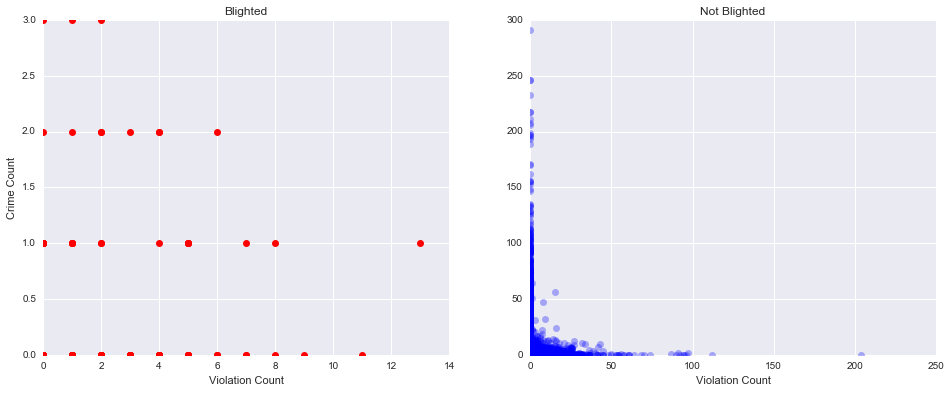

In [41]:
fig, ax=plt.subplots(1, 2, figsize=(16, 6), sharey=True)
plt.subplot(121)
plt.plot(blighted2['Violation_Count'],blighted2['Crime_Count'],'ro')
plt.title('Blighted')
plt.xlabel("Violation Count")
plt.ylabel("Crime Count")

plt.subplot(122)
plt.plot(not_blighted2['Violation_Count'],not_blighted2['Crime_Count'],'bo',alpha=0.3)
plt.xlabel("Violation Count")
plt.title('Not Blighted')

#fig.savefig('test.eps', format='eps')

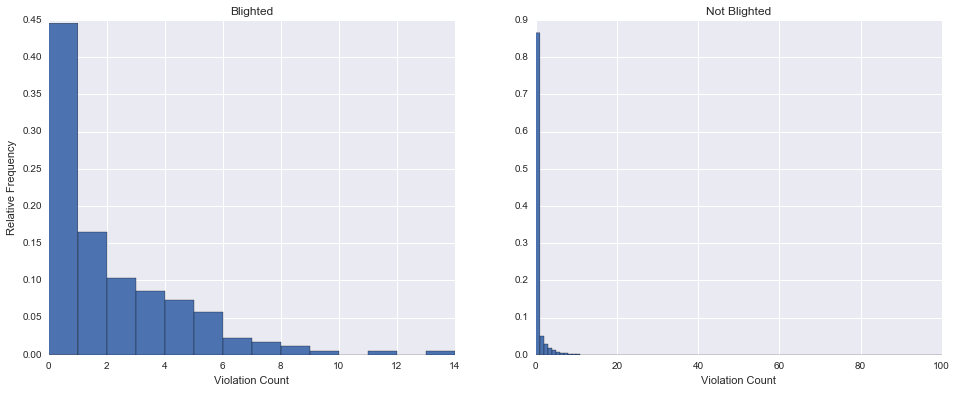

In [42]:
import numpy
fig,ax=plt.subplots(1, 2, figsize=(16, 6), sharey=True)
plt.subplot(121)
bins = numpy.linspace(0, 14, 15)
plt.hist(blighted2['Violation_Count'],bins, normed=1)
plt.title('Blighted')
plt.xlabel("Violation Count")
plt.ylabel("Relative Frequency")

plt.subplot(122)
bins = numpy.linspace(0, 230, 231)
plt.hist(not_blighted2['Violation_Count'],bins, normed=1)
plt.title('Not Blighted')
plt.xlabel("Violation Count")
plt.axis([0, 100, 0.0, 0.9])
fig.savefig('test.eps', format='eps')

From the above figures we can see that of all the not-blighted buildings, there are about 84% of them have zero violation count. For blighted buildings, the relative frequency of the zero violation count buildings is much lower (0.45).

[0, 100, 0.0, 10000]

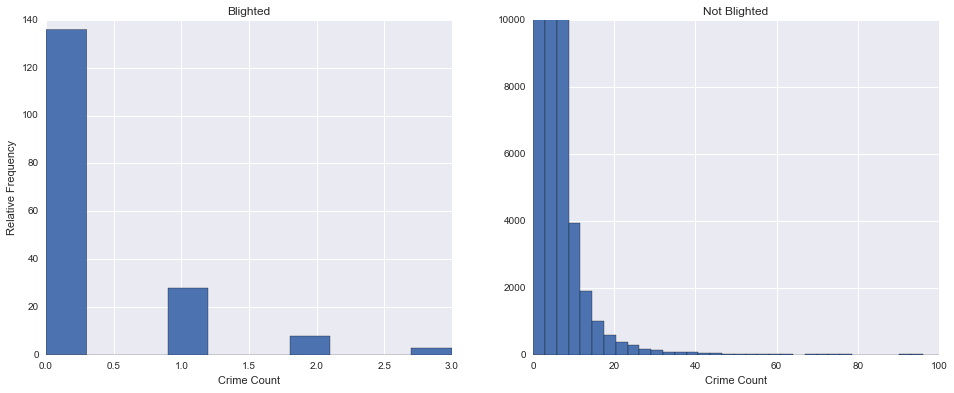

In [43]:
fig,ax=plt.subplots(1, 2, figsize=(16, 6), sharey=True)
plt.subplot(121)
bins = numpy.linspace(0, 14, 15)
plt.hist(blighted2['Crime_Count'])
plt.title('Blighted')
plt.xlabel("Crime Count")
plt.ylabel("Relative Frequency")

plt.subplot(122)
bins = numpy.linspace(0, 230, 231)
plt.hist(not_blighted2['Crime_Count'],100)
plt.title('Not Blighted')
plt.xlabel("Crime Count")
plt.axis([0, 100, 0.0, 10000])
#fig.savefig('test.eps', format='eps')

[0, 100, 0.0, 1000]

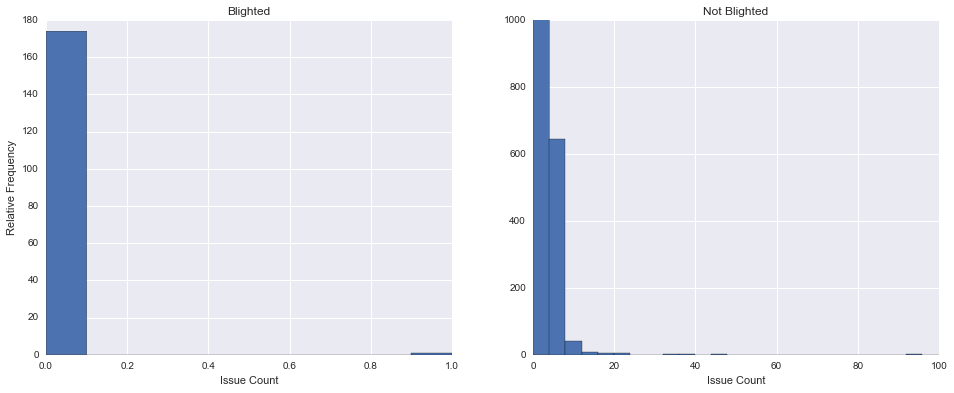

In [44]:
fig,ax=plt.subplots(1, 2, figsize=(16, 6), sharey=True)
plt.subplot(121)
bins = numpy.linspace(0, 14, 15)
plt.hist(blighted2['Issue_Count'])
plt.title('Blighted')
plt.xlabel("Issue Count")
plt.ylabel("Relative Frequency")

plt.subplot(122)
bins = numpy.linspace(0, 230, 231)
plt.hist(not_blighted2['Issue_Count'],100)
plt.title('Not Blighted')
plt.xlabel("Issue Count")
plt.axis([0, 100, 0.0, 1000])
#fig.savefig('test.eps', format='eps')

From the histograms of the crime-count and issue-count, we can see that our sample for blighted buildings may not be large enough. This sample generally has little crimes or issues. Note that in the not-blighted figures, the actual number at small x-axis region exceeds the y-axis limit. This limit is just set for clear view. The main feature is that the majority of the not-blighted bulidings have zero or nearly zero crime or issue count, but the histogram has a long tail.

In [45]:
demolitions2 = pd.merge(demolitions, locations, on=['Latitude', 'Longitude'])
demolitions2['IsBlighted'] = pd.Series(1,index=list(range(len(demolitions2.index))),dtype='int')
demolitions2.head()

Address     Parcel ID Contractor Name      Price Demolition Date  \
0    1319 Green     18009074.         Homrich  $11200.00      02/10/2016   
1   14612 Terry     22042996.         Homrich  $17500.00      02/10/2016   
2  14845 Sussex  22046773.001         Homrich  $16300.00      02/10/2016   
3   14850 Terry     22043010.         Homrich  $16900.00      02/10/2016   
4   15466 Cruse     22034167.         Homrich  $14300.00      02/10/2016   

  Commercial Building  Council_District   Latitude  Longitude  \
0                  No                 6  42.306876 -83.116669   
1                  No                 1  42.396117 -83.191366   
2                  No                 1  42.397525 -83.195185   
3                  No                 1  42.397671 -83.191433   
4                  No                 2  42.404791 -83.183196   

                                Location             x             y  \
0    1319 Green\n(42.306876, -83.116669)  14843.189166   6780.221847   
1   14612 Terry\n(42.396117, -83.191366)   8705.030704  16703.368296   
2  14845 Sussex\n(42.397525, -83.195185)   8391.207831  16859.930752   
3   14850 Terry\n(42.397671, -83.191433)   8699.525040  16876.165212   
4   15466 Cruse\n(42.404791, -83.183196)   9376.393070  17667.873089   

   Building_ID  IsBlighted  
0      2208374           1  
1      5436720           1  
2      5485514           1  
3      5492054           1  
4      5749267           1

In [46]:
new_blighted = demolitions2[['Building_ID','IsBlighted']]
new_blighted = new_blighted.rename(index=str,columns={"IsBlighted": "IsNewBlighted"})
print(len(new_blighted.index))
new_blighted = new_blighted.drop_duplicates()
print(len(new_blighted.index))
new_blighted.head()

10509
10465


Building_ID  IsNewBlighted
0      2208374              1
1      5436720              1
2      5485514              1
3      5492054              1
4      5749267              1

In [47]:
print(len(not_blighted2.index), len(new_blighted.index))
not_blighted3 = pd.merge(not_blighted2, new_blighted, how='outer', on='Building_ID')
print(len(not_blighted3.index))
not_blighted3.head()

767806 10465
767811


Building_ID  IsBlighted  Violation_Count  Crime_Count  Issue_Count  \
0    2208374.0         0.0              0.0          3.0          0.0   
1    5436720.0         0.0              0.0          1.0          0.0   
2    5485514.0         0.0              2.0          0.0          0.0   
3    5492054.0         0.0              1.0          0.0          0.0   
4    5749267.0         0.0              0.0          1.0          0.0   

   IsNewBlighted  
0            1.0  
1            1.0  
2            1.0  
3            1.0  
4            1.0

In [48]:
not_blighted3['IsNewBlighted'] = not_blighted3['IsNewBlighted'].fillna(0)
print(len(not_blighted3.index))

not_blighted3 = not_blighted3.dropna(how='any')
print(len(not_blighted3.index))
not_blighted3.tail()

767811
767806


Building_ID  IsBlighted  Violation_Count  Crime_Count  Issue_Count  \
767801    6009759.0         0.0              0.0          0.0          1.0   
767802    6969058.0         0.0              0.0          0.0          1.0   
767803    6743956.0         0.0              0.0          0.0          1.0   
767804    7023873.0         0.0              0.0          0.0          1.0   
767805    3141618.0         0.0              0.0          0.0          1.0   

        IsNewBlighted  
767801            0.0  
767802            0.0  
767803            0.0  
767804            0.0  
767805            0.0

In [49]:
blighted3 = blighted2
blighted3['IsNewBlighted'] = pd.Series(1, index=list(range(len(blighted3.index))), dtype='int')

In [50]:
temp = not_blighted3[not_blighted3.IsNewBlighted == 1]
print(len(blighted3.index),len(temp.index))
blighted3 = blighted3.append(temp, ignore_index=True) #note that append may produce duplicate index
print(len(blighted3.index))
blighted3.head()

175 10460
10635


Building_ID  IsBlighted  Violation_Count  Crime_Count  Issue_Count  \
0    3252359.0         1.0              0.0          0.0          0.0   
1    4438094.0         1.0              0.0          0.0          0.0   
2    3002531.0         1.0              0.0          0.0          0.0   
3    5409381.0         1.0              0.0          0.0          0.0   
4    6018081.0         1.0              1.0          0.0          0.0   

   IsNewBlighted  
0            1.0  
1            1.0  
2            1.0  
3            1.0  
4            1.0

In [51]:
temp = not_blighted3[not_blighted3.IsNewBlighted == 0]
temp.index =list(range(len(temp.index)))
not_blighted3 = temp

In [52]:
not_blighted3.head()

Building_ID  IsBlighted  Violation_Count  Crime_Count  Issue_Count  \
0    3651267.0         0.0              2.0          1.0          0.0   
1    6276913.0         0.0              3.0          0.0          0.0   
2    6689854.0         0.0             12.0          1.0          0.0   
3    3204255.0         0.0             15.0          0.0          0.0   
4    6005890.0         0.0              4.0          1.0          0.0   

   IsNewBlighted  
0            0.0  
1            0.0  
2            0.0  
3            0.0  
4            0.0

Now we have two data frames **blighted3** and **not_blighted3** which represents the blighted buildings and not-blighted building. Note we label the buildings in both demolitions and future_demolitions as blighted. The current **blighted3** data frame contains much more records than the **blighted2** table.

In [53]:
count_blighted = len(blighted3)
count_notblighted = len(not_blighted3)
print("the number of blighted building is",count_blighted,"and the number of not-blighted building is",count_notblighted)

the number of blighted building is 10635 and the number of not-blighted building is 757346


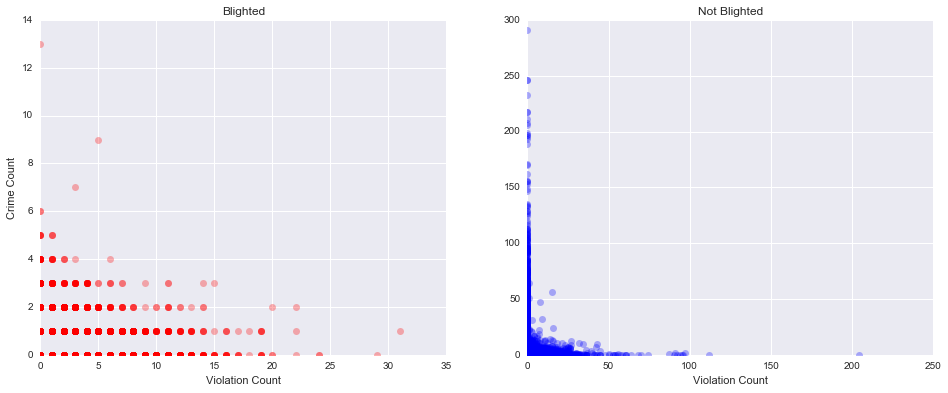

In [54]:
fig, ax=plt.subplots(1, 2, figsize=(16, 6), sharey=True)
plt.subplot(121)
plt.plot(blighted3['Violation_Count'],blighted3['Crime_Count'],'ro',alpha = 0.3)
plt.title('Blighted')
plt.xlabel("Violation Count")
plt.ylabel("Crime Count")

plt.subplot(122)
plt.plot(not_blighted3['Violation_Count'],not_blighted3['Crime_Count'],'bo',alpha=0.3)
plt.xlabel("Violation Count")
plt.title('Not Blighted')

[0, 30, 0.0, 0.9]

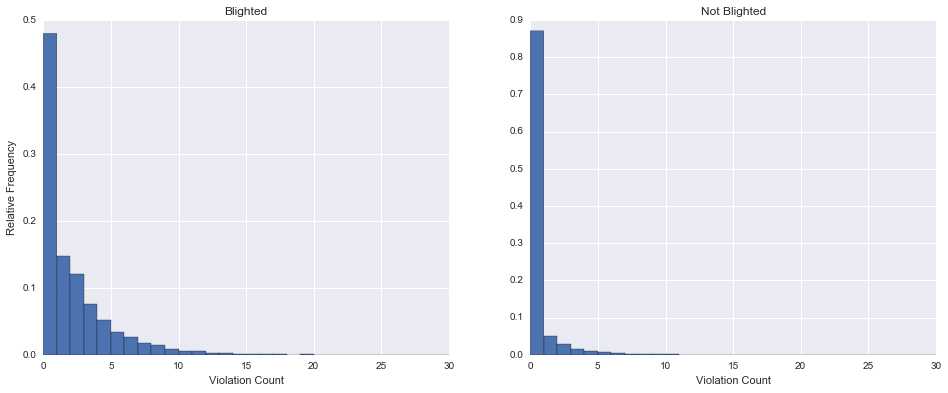

In [55]:
import numpy
fig,ax=plt.subplots(1, 2, figsize=(16, 6), sharey=True)
plt.subplot(121)
bins = numpy.linspace(0, 30, 31)
plt.hist(blighted3['Violation_Count'],bins, normed=1)
plt.title('Blighted')
plt.xlabel("Violation Count")
plt.ylabel("Relative Frequency")

plt.subplot(122)
bins = numpy.linspace(0, 230, 231)
plt.hist(not_blighted3['Violation_Count'],bins, normed=1)
plt.title('Not Blighted')
plt.xlabel("Violation Count")
plt.axis([0, 30, 0.0, 0.9])
#fig.savefig('test.eps', format='eps')

[0, 40, 0.0, 0.7]

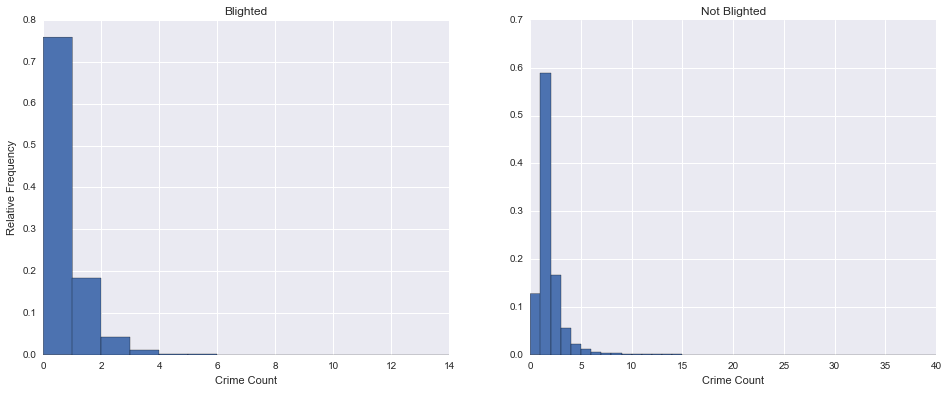

In [56]:
fig,ax=plt.subplots(1, 2, figsize=(16, 6), sharey=True)
plt.subplot(121)
bins = numpy.linspace(0, 14, 15)
plt.hist(blighted3['Crime_Count'],bins, normed=1)
plt.title('Blighted')
plt.xlabel("Crime Count")
plt.ylabel("Relative Frequency")

plt.subplot(122)
bins = numpy.linspace(0, 300, 301)
plt.hist(not_blighted3['Crime_Count'], bins, normed = 1)
plt.title('Not Blighted')
plt.xlabel("Crime Count")
plt.axis([0, 40, 0.0, 0.7])

[0, 10, 0.0, 1]

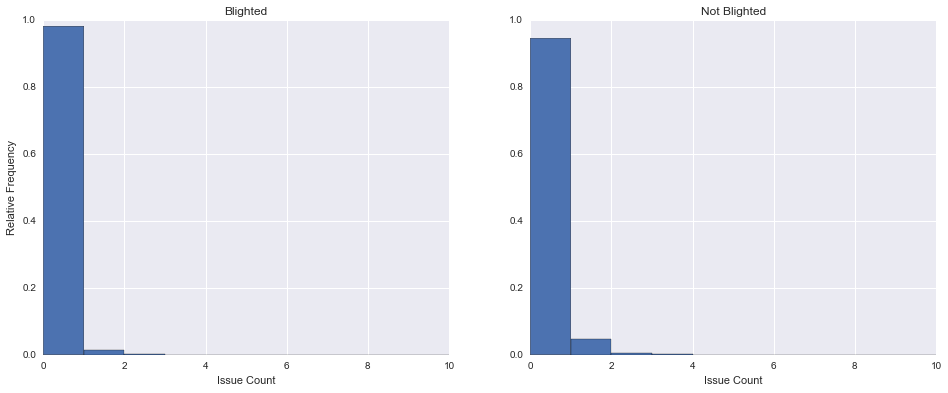

In [57]:
fig,ax=plt.subplots(1, 2, figsize=(16, 6), sharey=True)
plt.subplot(121)
bins = numpy.linspace(0, 10, 11)
plt.hist(blighted3['Issue_Count'],bins, normed=1)
plt.title('Blighted')
plt.xlabel("Issue Count")
plt.ylabel("Relative Frequency")

plt.subplot(122)
bins = numpy.linspace(0, 400, 401)
plt.hist(not_blighted3['Issue_Count'], bins, normed = 1)
plt.title('Not Blighted')
plt.xlabel("Issue Count")
plt.axis([0, 10, 0.0, 1])

Now we will randomly select 10000 records out of **blighted3** and **not_blighted3** as our sample. Then we will devided the sample into training set and test set.

In [58]:
sample_blighted = blighted3.sample(n=10000)
sample_notblighted = not_blighted3.sample(n=10000)

In [59]:
sample_blighted = sample_blighted[['Violation_Count','Crime_Count','Issue_Count','IsNewBlighted']]
sample_notblighted = sample_notblighted[['Violation_Count','Crime_Count','Issue_Count','IsNewBlighted']]
sample = sample_blighted.append(sample_notblighted)

[0, 35, 0, 20]

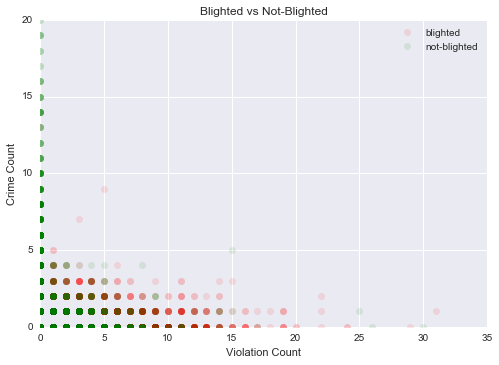

In [60]:
plt.plot(sample_blighted['Violation_Count'],sample_blighted['Crime_Count'],'ro',alpha = 0.1)
plt.plot(sample_notblighted['Violation_Count'],sample_notblighted['Crime_Count'],'go',alpha = 0.1)
plt.legend(['blighted','not-blighted'])
plt.title('Blighted vs Not-Blighted')
plt.xlabel("Violation Count")
plt.ylabel("Crime Count")
plt.axis([0, 35, 0, 20])

[0, 16, 0.0, 0.9]

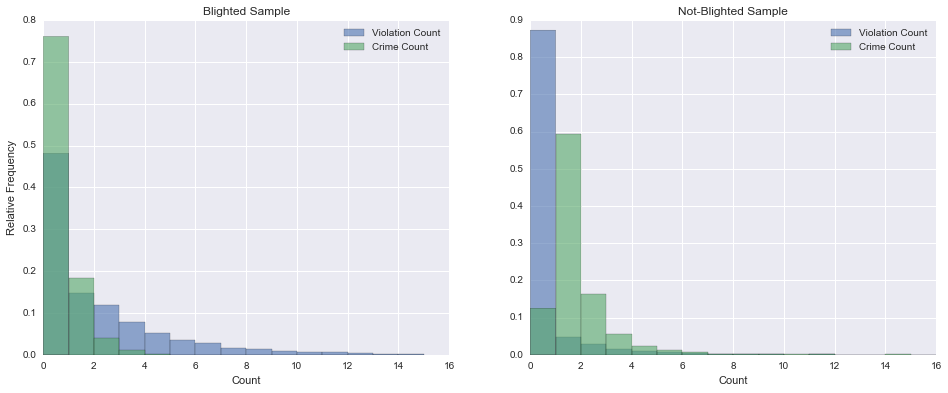

In [61]:
fig,ax=plt.subplots(1, 2, figsize=(16, 6), sharey=True)
plt.subplot(121)
bins = numpy.linspace(0, 15, 16)
plt.hist(sample_blighted['Violation_Count'],bins, normed=1,alpha=0.6)
plt.hist(sample_blighted['Crime_Count'],bins, normed=1,alpha=0.6)
plt.title('Blighted Sample')
plt.legend(['Violation Count','Crime Count'])
plt.xlabel("Count")
plt.ylabel("Relative Frequency")

plt.subplot(122)
bins = numpy.linspace(0, 300, 301)
plt.hist(sample_notblighted['Violation_Count'],bins, normed=1,alpha=0.6)
plt.hist(sample_notblighted['Crime_Count'], bins, normed = 1,alpha=0.6)
plt.legend(['Violation Count','Crime Count'])
plt.title('Not-Blighted Sample')
plt.xlabel("Count")
plt.axis([0, 16, 0.0, 0.9])

In [62]:
sample.head()

Violation_Count  Crime_Count  Issue_Count  IsNewBlighted
629               0.0          2.0          0.0            1.0
1570              0.0          2.0          0.0            1.0
986               0.0          1.0          0.0            1.0
695               1.0          0.0          0.0            1.0
1238              4.0          0.0          0.0            1.0

## Model Selection and Training

We first build a model based on a single feature: Violation_Count, namely the number of records in *detroit-blight-violations.csv* associated with that building.

In [92]:
X = sample[['Violation_Count']]
y = sample['IsNewBlighted']

In [93]:
from sklearn import cross_validation
from sklearn import svm

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2, random_state=0)

In [94]:
clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
clf.score(X_test, y_test) 

0.69550000000000001

In [97]:
modelsmv = svm.SVC(kernel='rbf', C=1)
scores = cross_validation.cross_val_score(modelsmv, X_train, y_train, cv=5)

In [101]:
print(scores)

[ 0.68884724  0.69875     0.69625     0.6875      0.71209753]


In [103]:
modelsmv = svm.SVC(kernel='rbf', C=10)
scores = cross_validation.cross_val_score(modelsmv, X_train, y_train, cv=5)
print(scores)

[ 0.68884724  0.69875     0.69625     0.6875      0.71178493]


One feature doesnot seem to work well. We include the number of crimes associted with a building to the feature vector.

In [104]:
X = sample[['Violation_Count','Crime_Count']]
y = sample['IsNewBlighted']
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2, random_state=0)

modelsmv = svm.SVC(kernel='rbf', C=1)
scores = cross_validation.cross_val_score(modelsmv, X_train, y_train, cv=5)
print(scores)

[ 0.8556701   0.8696875   0.8584375   0.86        0.86402001]


Now the accuracy has been improved from around 70% to around 86%! We need to tune the superparameter see what is the best learning model for the data.

In [105]:
modelsmv = svm.SVC(kernel='rbf', C=10)
scores = cross_validation.cross_val_score(modelsmv, X_train, y_train, cv=5)
print(scores)

[ 0.8553577   0.8684375   0.85875     0.85875     0.86402001]


In [106]:
modelsmv = svm.SVC(kernel='rbf', C=0.1)
scores = cross_validation.cross_val_score(modelsmv, X_train, y_train, cv=5)
print(scores)

[ 0.8547329   0.869375    0.858125    0.8578125   0.86370741]


In [111]:
modelsmv = svm.SVC(kernel='linear', C=1)
scores = cross_validation.cross_val_score(modelsmv, X_train, y_train, cv=5)
print(scores)

[ 0.82380506  0.8309375   0.8234375   0.828125    0.83369803]


Obviouly, the linear kernel in SVM is less suitale for our data set than the Gaussian kernel. The accuracy is about 83%. Within the model of SMV with Gaussian kernel, changing parameter C doesn't have large effect in the model performance.

We did not scale our feature vector. Now we preprocess the training feature set by standardization and still use 5-fold cross validation in the following.

In [110]:
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
clf = make_pipeline(preprocessing.StandardScaler(), svm.SVC(C=1))
cross_validation.cross_val_score(clf, X_train, y_train, cv=5)

array([ 0.85598251,  0.8696875 ,  0.858125  ,  0.859375  ,  0.8643326 ])

The results are very close to the model without scaling. Now we add one more feature, the number of issues reported associates with a building.

In [117]:
X = sample[['Violation_Count','Crime_Count','Issue_Count']]
y = sample['IsNewBlighted']
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2, random_state=0)

model_smv = make_pipeline(preprocessing.StandardScaler(), svm.SVC(C=1))
score_smv = cross_validation.cross_val_score(model_smv, X_train, y_train, cv=5)
print(score_smv)
print(np.average(score_smv))

[ 0.86722899  0.8815625   0.8746875   0.8728125   0.88121288]
0.875500873993


We can see the accuracy improves slightly with this additional feature: Issue_Count.

In [120]:
from sklearn import tree

model_dt = tree.DecisionTreeClassifier()
score_dt = cross_validation.cross_val_score(model_dt, X_train, y_train, cv=5)
print(score_dt)
print("the average cross validation score by decition tree is",np.average(score_dt))

[ 0.86722899  0.8796875   0.875       0.871875    0.8783995 ]
the average cross validation score by decition tree is 0.874438198157


In [125]:
from sklearn.externals.six import StringIO

model_dt = model_dt.fit(X_train, y_train)

with open("dt.dot",'w') as f:
    f = tree.export_graphviz(model_dt, out_file = f)

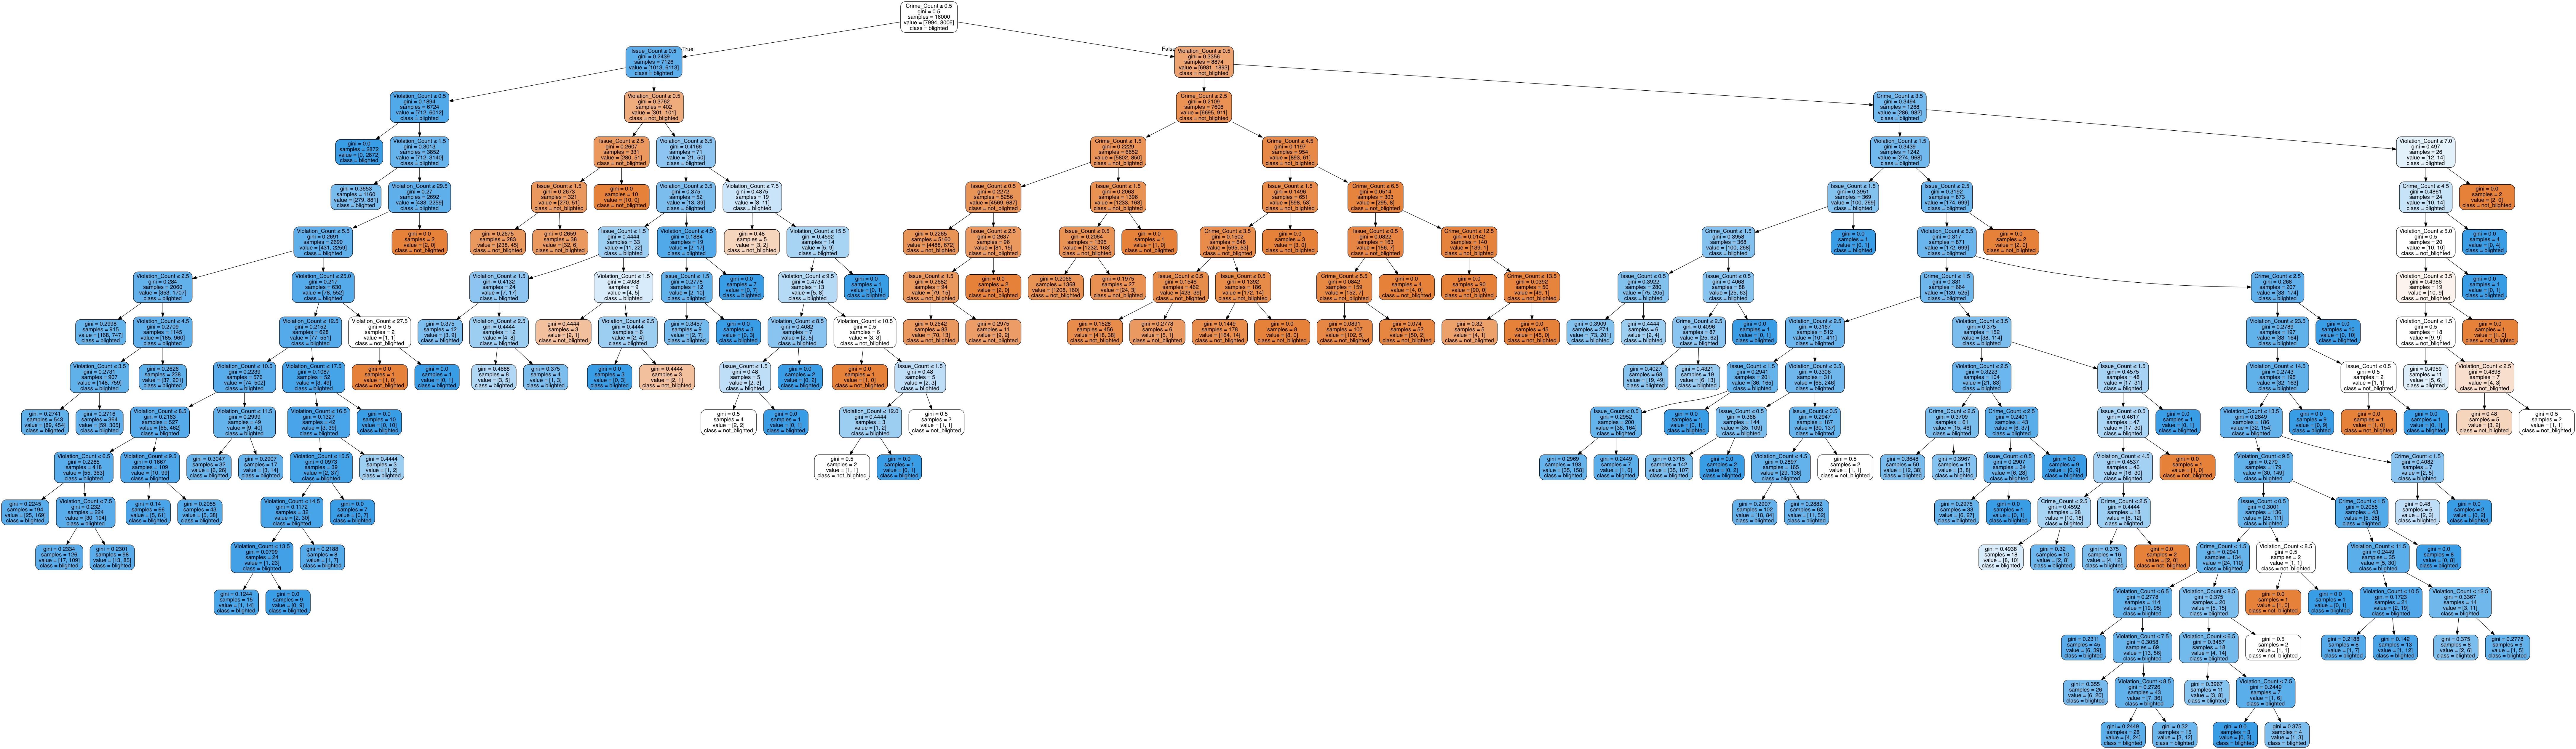

In [153]:
from IPython.display import Image  
import pydotplus

dot_data = StringIO()  
tree.export_graphviz(model_dt, out_file=dot_data,  
                         feature_names=X_train.columns,  
                         class_names=['not_blighted','blighted'],  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_pdf("dt.pdf") 
Image(graph.create_png())  

The decision tree model produces a similar accuracy score as the SVM. However, the above tree looks too complicated. We restrict the max depth of the tree and test what depth produces the most accurate model by cross validation.

In [184]:
for i in list(range(1,11,1)):
    model_dt = tree.DecisionTreeClassifier(max_depth = i)
    score_dt = cross_validation.cross_val_score(model_dt, X_train, y_train, cv=5)
    print("For max_depth=",i,", the CV scores are",score_dt, "and the mean is", score_dt.mean())

For max_depth= 1 , the CV scores are [ 0.81693221  0.825       0.8115625   0.81375     0.8246327 ] and the mean is 0.818375481281
For max_depth= 2 , the CV scores are [ 0.86754139  0.880625    0.8740625   0.8715625   0.8780869 ] and the mean is 0.874375659094
For max_depth= 3 , the CV scores are [ 0.8684786   0.8815625   0.874375    0.8740625   0.88152548] and the mean is 0.87600081543
For max_depth= 4 , the CV scores are [ 0.8684786   0.8815625   0.874375    0.8740625   0.88152548] and the mean is 0.87600081543
For max_depth= 5 , the CV scores are [ 0.86754139  0.8815625   0.875       0.8734375   0.88058768] and the mean is 0.875625815393
For max_depth= 6 , the CV scores are [ 0.86754139  0.88125     0.875       0.87375     0.88090028] and the mean is 0.875688334931
For max_depth= 7 , the CV scores are [ 0.86691659  0.8815625   0.8746875   0.873125    0.88027509] and the mean is 0.875313334906
For max_depth= 8 , the CV scores are [ 0.86691659  0.881875    0.8746875   0.873125    0.880

In [163]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(n_estimators=10, max_features=3, max_depth=None, min_samples_split=1,random_state=0)
score_rf = cross_validation.cross_val_score(model_rf, X_train, y_train, cv=5)
print(score_rf)
print("the average cross validation score by random forests is",np.average(score_rf))

[ 0.86754139  0.8803125   0.8734375   0.8725      0.8787121 ]
the average cross validation score by random forests is 0.874500698169


In [188]:
model_rf = RandomForestClassifier(n_estimators=10, max_features=3, max_depth=4, min_samples_split=1,random_state=0)
score_rf = cross_validation.cross_val_score(model_rf, X_train, y_train, cv=5)
print(score_rf)
print("the average cross validation score by random forests with max_depth=4 is",np.average(score_rf))

[ 0.8684786   0.8815625   0.8740625   0.874375    0.88121288]
the average cross validation score by random forests with max_depth=4 is 0.875938295892


In the above, we also test the accuracy of the Random Forests model which is 0.8759 when max_depth=4. This is slightly less than the accuracy of the Decision Tree model with max_depth=4 (0.8760). The accuracy of the depth-4 tree is also slightly higher than that of the SVM model (0.8755). Therefore we take Decision Tree as our final model for simplicity and effectiveness.

We can see that the best Decision Tree model has max_depth = 3 or 4 with the mean accuracy = 0.8760. We choose max_depth = 4 and show the graph of the decison tree. We will also test our model on the test data set which are held out at the beginning.

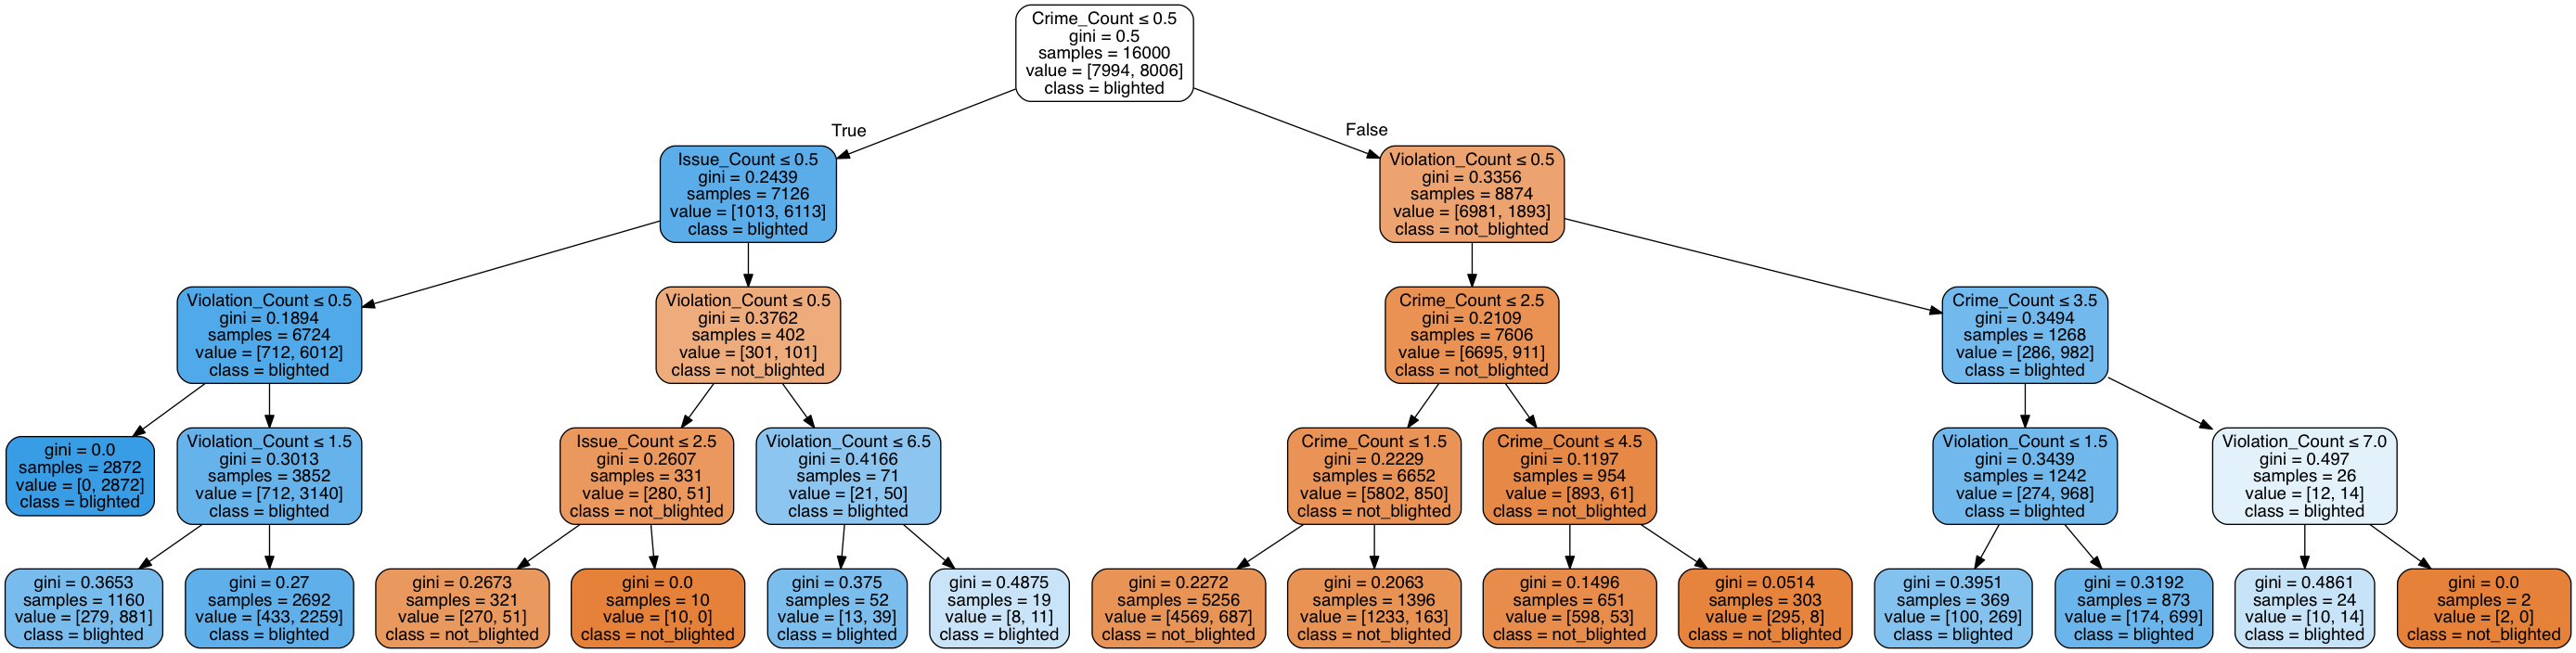

In [185]:
model_dt = tree.DecisionTreeClassifier(max_depth = 4)

model_dt = model_dt.fit(X_train, y_train)
dot_data = StringIO()  
tree.export_graphviz(model_dt, out_file=dot_data,  
                         feature_names=X_train.columns,  
                         class_names=['not_blighted','blighted'],  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_pdf("dt_4.pdf") 
Image(graph.create_png())  

The advantage of this decision tree model is that we can interpret the results directly from the graph. The orange leaves represent the not-blighted buildings and the blue represent the blighted ones. The branch right to the root with Crime_Count > 0.5 and Violation_Count <= 0.5 (or equivalently Violation_Count = 0.5) are all classified as not-blighted. The next right branch with Crime_Count > 0.5 and 0.5 < Violation_Count <= 3.5 are mostly classified as blighted. This indicates in the area where crimes happen (Crime_Count > 0), the number of blight violations is the critical factor in determining whether a building is blighted or not. Except for some outliers, the non-blighted buildings don't have any blight violation records. While the blighted ones usually have nonzero Violation_Count, the Crime_Count is usually less than 4.

On the other side (left side), where Crime_Count <= 0.5 (this simply means Crime_Count = 0), we can see if Issue_Count = 0, then almost all the samples are blighted buildings. This tells us that in the areas where no crimes occur and no issues are reported, the buildings are probably just blighted, and zero crimes or issues might just indicate a low population. At the branch of Crime_Count = 0 and Issue_Count > 0.5, if Violation_Count = 0, then the buildings are not-blighted, otherwise they are mostly blighted. This may tell us that people tend to report issues but not violate the blight regulation if they still live there, but after they abandon the house, the number of blight violations increase.

The root node is whether the Crime_Count is zero or not, and there are many blighted and non-blighted records on either side of the root. This indicates that the number of criminal incidents is not critical in determining whether a building is blighted or not. 

In [189]:
model_dt.score(X_test, y_test)

0.87450000000000006

In [196]:
from sklearn.metrics import classification_report

y_true = y_test
y_pred = model_dt.predict(X_test)
target_names = ['not-blighted', 'blighted']
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

not-blighted       0.88      0.87      0.87      2006
    blighted       0.87      0.88      0.87      1994

 avg / total       0.87      0.87      0.87      4000



Our model has 87.45% accuracy testing againest the test data set, and the precision and recall for each category is roughly the same as the accuracy. The metrics show that our model is reasonably good considering that the data are from the real world (the Detroite goverment data portal). Note that we have banlanced the category by selecting the same number of blighted and not-blighted from the total data set to form our training set. Next, we want to test our model for the total data set, which is extremely skewed with the number of the not-blighted buildings much larger than the blighted ones.

In [191]:
total_blighted = blighted3[['Violation_Count','Crime_Count','Issue_Count','IsNewBlighted']]
total_notblighted = not_blighted3[['Violation_Count','Crime_Count','Issue_Count','IsNewBlighted']]
total_sample = total_blighted.append(total_notblighted)

Xt = total_sample[['Violation_Count','Crime_Count','Issue_Count']]
yt = total_sample['IsNewBlighted']

model_dt.score(Xt, yt)

0.87101503813245384

In [194]:
y_true = yt
y_pred = model_dt.predict(Xt)
target_names = ['not-blighted', 'blighted']
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

not-blighted       1.00      0.87      0.93    757346
    blighted       0.09      0.88      0.16     10635

 avg / total       0.99      0.87      0.92    767981



We want to find out the blighted buildings through the our model. The recall of the blighted class is 0.88 which is reasonably good. This means 88% of the blighted buldings are identified thourgh our model. The precison of the blighted class is very low though. This tells us that a large portion of the buildings identified as blighted are not really blighted. Since we label a building as blighted simply from the fact that it is demolished or to be demolished in the future, we cannot rule out the possibility that the building is actually blighted but not noticed by the government yet. The buildings identified as blighted through our model are worth future investigation. They may be already blighted but not reported, or will probably become blighted in the future.

On the other hand, the precision and recall of not-blighted class are reasonably good.

Next, we also train a Decision Tree model with the entire data set in the following. We want to check how the performance is different for a model trained with the skewed real data set.

In [208]:
Xt_train, Xt_test, yt_train, yt_test = cross_validation.train_test_split(Xt, yt, test_size=0.2, random_state=0)

model_dt2 = tree.DecisionTreeClassifier(max_depth = 4)
score_dt2 = cross_validation.cross_val_score(model_dt2, Xt_train, yt_train, cv=5)
print("The scores are", score_dt2, "and the mean is",score_dt2.mean())

The scores are [ 0.99100727  0.9908445   0.99115376  0.99124328  0.99101533] and the mean is 0.991052826836


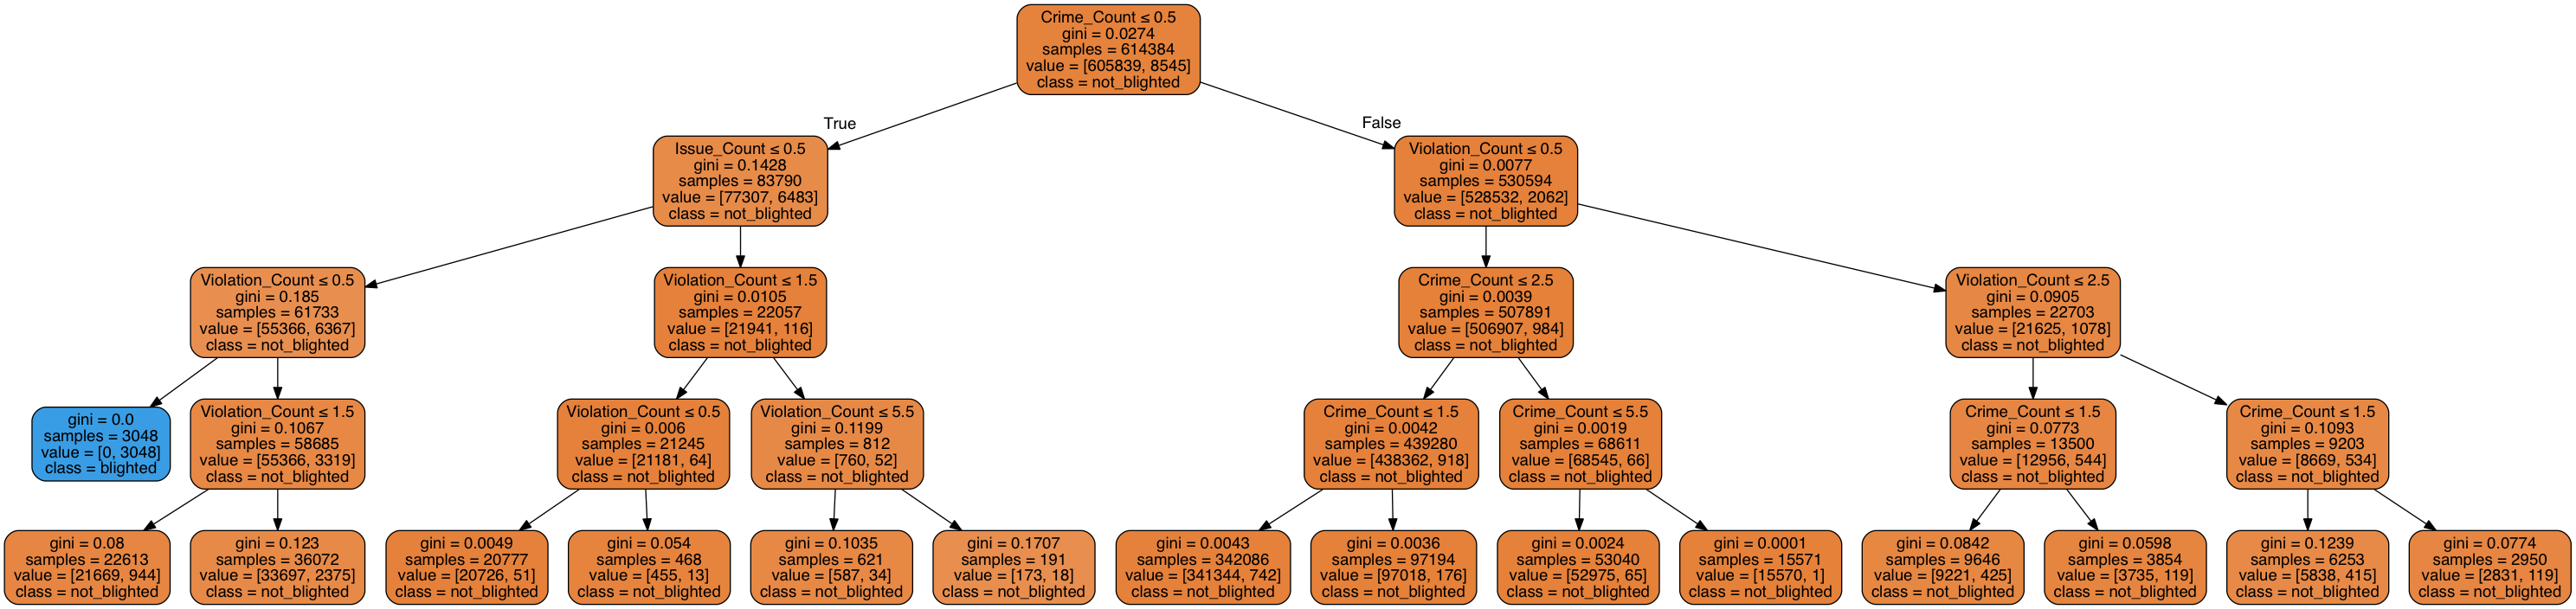

In [209]:
model_dt2 = model_dt2.fit(Xt_train, yt_train)

dot_data = StringIO()  
tree.export_graphviz(model_dt2, out_file=dot_data,  
                         feature_names=Xt_train.columns,  
                         class_names=['not_blighted','blighted'],  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_pdf("dtl_4_totalsample.pdf") 
Image(graph.create_png()) 

In [210]:
y_true = yt_test
y_pred = model_dt2.predict(Xt_test)
target_names = ['not-blighted', 'blighted']
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

not-blighted       0.99      1.00      1.00    151507
    blighted       1.00      0.37      0.54      2090

 avg / total       0.99      0.99      0.99    153597



In [211]:
model_dt2 = tree.DecisionTreeClassifier(max_depth = None)
score_dt2 = cross_validation.cross_val_score(model_dt2, Xt_train, yt_train, cv=5)
print("The CV scores are", score_dt2, "and the mean is",score_dt2.mean())

model_dt2 = model_dt2.fit(Xt_train, yt_train)
y_true = yt_test
y_pred = model_dt2.predict(Xt_test)
target_names = ['not-blighted', 'blighted']
print(classification_report(y_true, y_pred, target_names=target_names))

The CV scores are [ 0.99099913  0.99085264  0.99116189  0.99123514  0.99101533] and the mean is 0.991052826836
              precision    recall  f1-score   support

not-blighted       0.99      1.00      1.00    151507
    blighted       1.00      0.37      0.54      2090

 avg / total       0.99      0.99      0.99    153597



The Decision Tree models (trained with the total data set) with max_depth=4 and max_depth=None behave identically as the metrics show. The precision of the blighted class is 1.0, indicating that all the identifed-as-blighted buildings are truly blighted. However, the recall of the blighted class is low (0.37), indicating that a large protion (63%) of the blighted buildings are not identified. This is not what we want. The goverment want to find out the potential blighted buildings so that actions can be taken to prevent it. We can tolerate a low precision, but we don't want to leave out many truly blighted buildings unidentifed in our model.

## Conclusion

Successfully trained a Decision Tree model to predict the potential blight in the city of Detroit. The recall of the blighted class in our model is pretty high, which shows that our model is capable to identify the blighted buildings from a much larger set of blighted and not-blighted buildings. Our model has a low precision for the blighted class, this shows that some of the not-blighted buildings have very similar characters as the blighted ones. Although these not-blighted buildings are misclassified according to the demolition and future-demolition list, they may be actually blighted or near blighted and worth further investigation.